<a href="https://colab.research.google.com/github/r0cketr1kky/COVID-19_X-Ray/blob/master/IntegratedScoreCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install tf-explain

     |████████████████████████████████| 51kB 4.2MB/s 


In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
!pip install saliency

In [0]:
 class InvalidState(ValueError):
    def __init__(self, message, *args):
        self.message = message # without this you may get DeprecationWarning
        super(InvalidState, self).__init__(message, *args)

In [0]:
import numpy as np
from skimage.transform import resize


def resize_activations(enhanced_model_output, input_shape):
    resized_activations = []
    for i in range(enhanced_model_output.shape[-1]):
        # resizing every activation map to original input image spatial dimensions
        resized_activations.append(resize(enhanced_model_output[..., i], input_shape, preserve_range=True))
    return np.array(resized_activations)


def normalize_activations(activation_maps):
    flattened = activation_maps.reshape((activation_maps.shape[0], -1))
    # min/max for each map
    max_a = np.max(flattened, axis=1)
    min_a = np.min(flattened, axis=1)

    # make norm = 1 where diff is zero (instead of adding/removing small epsilon)
    diffs = np.where(max_a > min_a, max_a - min_a, 1)
    return (activation_maps - min_a.reshape((-1, 1, 1))) / diffs.reshape((-1, 1, 1))

In [0]:
import tensorflow as tf
from tensorflow.keras import Model
import numpy as np

class ScoreCAM:
    def __init__(self, model_input, last_conv_output, softmax_output, input_shape, cam_batch_size=None):
        """
        Prepares class activation mappings
        :param model_input: input layer of CNN, normally takes batch of images as an input. Currently batch must be limited to a single image
        :param last_conv_output: last convolutional layer. The last conv layer contains the most complete information about image.
        :param softmax_output: flat softmax (or similar) layer describing the class certainty
        :param input_shape: Expecting a batch of a single input sample 1 x M X N X ...; it is assumed that 2D image of M x N dimensions is served as an input, which can be multiplied with a 2D-mask.
        :param cam_batch_size: Optional, defaults to None, which will result in inference of batches of size 32.
        """
        self.model_input = model_input
        self.last_conv_output = last_conv_output
        self.softmax_output = softmax_output
        self.last_conv_model = Model(inputs=model_input, outputs=last_conv_output)
        self.softmax_model = Model(inputs=model_input, outputs=softmax_output)
        self.input_shape = input_shape
        self.cam_batch_size = cam_batch_size

        self.normalized_maps = None
        self.classes_activation_scale = None

    def prepare_cam(self, input):
        output_conv = self.last_conv_model.predict(input)
        # Only first image from convolutions will be used
        resized = resize_activations(output_conv[0], self.input_shape)
        # filter_size x input_shape[0] x input_shape[1] - resized to original input dimensions
        normalized_maps = normalize_activations(resized)

        # repeat input
        repeat_input = np.tile(input, (normalized_maps.shape[0], 1, 1, 1))
        expanded_activation_maps = np.expand_dims(normalized_maps, axis=3)
        masked_images = np.multiply(repeat_input, expanded_activation_maps)
        # input: filter_size x input_shape[0] x input_shape[1] -> Output filter_size x Classes_Count
        self.classes_activation_scale = self.softmax_model.predict(masked_images,
                                                                   batch_size=self.cam_batch_size)
        self.normalized_maps = normalized_maps

        print(self.classes_activation_scale.shape)

        print(self.normalized_maps.shape)

    def get_class_heatmap(self, class_id):
        if self.normalized_maps is None or self.classes_activation_scale is None:
            raise InvalidState('Call prepare_cam before accessing get_class_heatmap, '
                               'activations must be prepared via prepare_cam')
        final_weights = self.classes_activation_scale[:, class_id]
        final_maps = np.multiply(self.normalized_maps, final_weights.reshape((-1, 1, 1)))
        # ReLU
        #print(final_maps.shape)
        final_maps_max = np.max(final_maps, axis=0)
        #print(final_maps_max.shape)
        final_class_activation_map = np.where(final_maps_max > 0, final_maps_max, 0)
        print(final_class_activation_map.shape)
        return final_class_activation_map

In [0]:
import tensorflow.keras, os 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255,
  rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        '/gdrive/My Drive/dataset',  
        target_size=(400,400),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        '/gdrive/My Drive/Validation',  
        target_size=(400,400), 
        batch_size=16,
        class_mode='categorical')


Found 44 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [0]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(400,400,3), activation="relu"))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [9]:
'''
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(AvgPool2D((4,4)))
model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4096 ,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))


'''
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 197, 32)      4640      
_________________________________________________________________
dropout (Dropout)            (None, 197, 197, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96, 64)        0

In [0]:
input_shape = (400, 400)
conv_layers = model.layers[-7].output
softmax_output = model.layers[-1].output

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=44//4,  
      epochs=10,
      verbose=1,
      batch_size=4,
      validation_steps=6//4,
      validation_data = validation_generator)

Epoch 1/10
11/11 [==============================] - 17s 2s/step - loss: 3.0513 - accuracy: 0.5119 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 2/10
11/11 [==============================] - 14s 1s/step - loss: 0.6652 - accuracy: 0.6466 - val_loss: 0.6935 - val_accuracy: 0.6667
Epoch 3/10
11/11 [==============================] - 14s 1s/step - loss: 0.4831 - accuracy: 0.8095 - val_loss: 0.6743 - val_accuracy: 0.5000
Epoch 4/10
11/11 [==============================] - 14s 1s/step - loss: 0.3239 - accuracy: 0.9009 - val_loss: 0.5986 - val_accuracy: 0.6667
Epoch 5/10
11/11 [==============================] - 14s 1s/step - loss: 0.3011 - accuracy: 0.8611 - val_loss: 0.6370 - val_accuracy: 0.6667
Epoch 6/10
11/11 [==============================] - 14s 1s/step - loss: 0.2373 - accuracy: 0.9224 - val_loss: 0.6336 - val_accuracy: 0.6667
Epoch 7/10
11/11 [==============================] - 14s 1s/step - loss: 0.3135 - accuracy: 0.8849 - val_loss: 0.6438 - val_accuracy: 0.6667
Epoch 8/10
11/11 [==

In [93]:
import keras
from keras_applications.vgg16 import preprocess_input
from keras_preprocessing.image import load_img, img_to_array

source_img = load_img('/gdrive/My Drive/covid-chestxray-dataset/images/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)
img.shape

(1, 400, 400, 3)

In [94]:
scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

(64, 2)
(64, 400, 400)


In [0]:
import math

def grid_display(array, num_rows=None, num_columns=None):
    """
    Display a list of images as a grid.
    Args:
        array (numpy.ndarray): 4D Tensor (batch_size, height, width, channels)
    Returns:
        numpy.ndarray: 3D Tensor as concatenation of input images on a grid
    """
    if num_rows is not None and num_columns is not None:
        total_grid_size = num_rows * num_columns
        if total_grid_size < len(array):
            warnings.warn(
                Warning(
                    "Given values for num_rows and num_columns doesn't allow to display "
                    "all images. Values have been overrided to respect at least num_columns"
                )
            )
            num_rows = math.ceil(len(array) / num_columns)
    elif num_rows is not None:
        num_columns = math.ceil(len(array) / num_rows)
    elif num_columns is not None:
        num_rows = math.ceil(len(array) / num_columns)
    else:
        num_rows = math.ceil(math.sqrt(len(array)))
        num_columns = math.ceil(math.sqrt(len(array)))

    number_of_missing_elements = num_columns * num_rows - len(array)
    # We fill the array with np.zeros elements to obtain a perfect square
    array = np.append(
        array,
        np.zeros((number_of_missing_elements, *array[0].shape)).astype(array.dtype),
        axis=0,
    )

    grid = np.concatenate(
        [
            np.concatenate(
                array[index * num_columns : (index + 1) * num_columns], axis=1
            )
            for index in range(num_rows)
        ],
        axis=0,
    )

    return grid

def transform_to_normalized_grayscale(tensor):
    """
    Transform tensor over RGB axis to grayscale.
    Args:
        tensor (tf.Tensor): 4D-Tensor with shape (batch_size, H, W, 3)
    Returns:
        tf.Tensor: 4D-Tensor of grayscale tensor, with shape (batch_size, H, W, 1)
    """
    grayscale_tensor = tf.reduce_mean(tensor, axis=-1)

    return grayscale_tensor

In [0]:
class IntegratedGradients:

    """
    Perform Integrated Gradients algorithm for a given input
    Paper: [Axiomatic Attribution for Deep Networks](https://arxiv.org/pdf/1703.01365.pdf)
    """

    def explain(self, validation_data, model, class_index, n_steps=10):
        """
        Compute Integrated Gradients for a specific class index
        Args:
            validation_data (Tuple[np.ndarray, Optional[np.ndarray]]): Validation data
                to perform the method on. Tuple containing (x, y).
            model (tf.keras.Model): tf.keras model to inspect
            class_index (int): Index of targeted class
            n_steps (int): Number of steps in the path
        Returns:
            np.ndarray: Grid of all the integrated gradients
        """
        images = validation_data

        interpolated_images = IntegratedGradients.generate_interpolations(
            images, n_steps
        )

        integrated_gradients = IntegratedGradients.get_integrated_gradients(
            interpolated_images, model, class_index, n_steps
        )

        gray = transform_to_normalized_grayscale(integrated_gradients)
        
        return gray

    @staticmethod
    @tf.function
    def get_integrated_gradients(interpolated_images, model, class_index, n_steps):
        """
        Perform backpropagation to compute integrated gradients.
        Args:
            interpolated_images (numpy.ndarray): 4D-Tensor of shape (N * n_steps, H, W, 3)
            model (tf.keras.Model): tf.keras model to inspect
            class_index (int): Index of targeted class
            n_steps (int): Number of steps in the path
        Returns:
            tf.Tensor: 4D-Tensor of shape (N, H, W, 3) with integrated gradients
        """
        with tf.GradientTape() as tape:
            inputs = tf.cast(interpolated_images, tf.float32)
            tape.watch(inputs)
            predictions = model(inputs)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, inputs)
        grads_per_image = tf.reshape(grads, (-1, n_steps, *grads.shape[1:]))

        integrated_gradients = tf.reduce_mean(grads_per_image, axis=1)

        return integrated_gradients

    @staticmethod
    def generate_interpolations(images, n_steps):
        """
        Generate interpolation paths for batch of images.
        Args:
            images (numpy.ndarray): 4D-Tensor of images with shape (N, H, W, 3)
            n_steps (int): Number of steps in the path
        Returns:
            numpy.ndarray: Interpolation paths for each image with shape (N * n_steps, H, W, 3)
        """
        baseline = np.zeros(images.shape[1:])

        return np.concatenate(
            [
                IntegratedGradients.generate_linear_path(baseline, image, n_steps)
                for image in images
            ]
        )

    @staticmethod
    def generate_linear_path(baseline, target, n_steps):
        """
        Generate the interpolation path between the baseline image and the target image.
        Args:
            baseline (numpy.ndarray): Reference image
            target (numpy.ndarray): Target image
            n_steps (int): Number of steps in the path
        Returns:
            List(np.ndarray): List of images for each step
        """
        return [
            baseline + (target - baseline) * index / (n_steps - 1)
            for index in range(n_steps)
        ]

    def save(self, grid, output_dir, output_name):
        """
        Save the output to a specific dir.
        Args:
            grid (numpy.ndarray): Grid of all the heatmaps
            output_dir (str): Output directory path
            output_name (str): Output name
        """
        save_grayscale(grid, output_dir, output_name)

In [0]:
#from tf_explain.core.integrated_gradients import *
x = IntegratedGradients().explain(img, model, 0)

In [130]:
x.shape

TensorShape([1, 400, 400])

In [141]:
ans = np.dot(x, scoreCAM.get_class_heatmap(0))
ans = np.reshape(ans, [400, 400])
ans.shape

(64, 400, 400)
(400, 400)
(400, 400)


(400, 400)

In [0]:
import matplotlib.pyplot as plt


def draw_original_and_heatmap(class_id):
    heatmap = ans
    f = plt.figure(figsize=(8,8))
    left = f.add_subplot(131)
    left.set_title("Original image")
    left.axis('off')
    left.imshow(source_img)
    
    right = f.add_subplot(132)    
    right.set_title("Heatmap for class {}".format(class_id))
    right.axis('off')
    right.imshow(heatmap, cmap='plasma')
    
    merged = f.add_subplot(133)    
    merged.set_title("Overlay for class {}".format(class_id))
    merged.axis('off')
    merged.imshow(source_img, alpha=0.5)
    merged.imshow(heatmap, cmap='plasma', alpha=0.5)

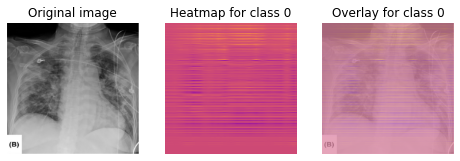

In [143]:
draw_original_and_heatmap(0)

In [145]:
ans1 = np.dot(x, scoreCAM.get_class_heatmap(1))
ans1 = np.reshape(ans1, [400, 400])
ans1.shape

(64, 400, 400)
(400, 400)
(400, 400)


(400, 400)

In [0]:
import matplotlib.pyplot as plt


def draw_original_and_heatmap(class_id):
    heatmap = ans1
    f = plt.figure(figsize=(8,8))
    left = f.add_subplot(131)
    left.set_title("Original image")
    left.axis('off')
    left.imshow(source_img)
    
    right = f.add_subplot(132)    
    right.set_title("Heatmap for class {}".format(class_id))
    right.axis('off')
    right.imshow(heatmap, cmap='plasma')
    
    merged = f.add_subplot(133)    
    merged.set_title("Overlay for class {}".format(class_id))
    merged.axis('off')
    merged.imshow(source_img, alpha=0.5)
    merged.imshow(heatmap, cmap='plasma', alpha=0.45)

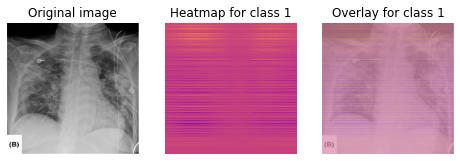

In [153]:
draw_original_and_heatmap(1)

In [0]:
source_img = load_img('/gdrive/My Drive/covid-chestxray-dataset/images/1-s2.0-S1684118220300682-main.pdf-002-a1.png', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

In [155]:
scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

(64, 2)
(64, 400, 400)


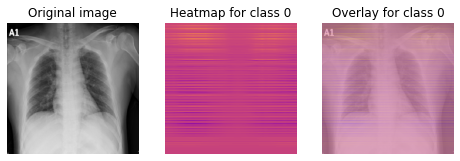

In [156]:
draw_original_and_heatmap(0)

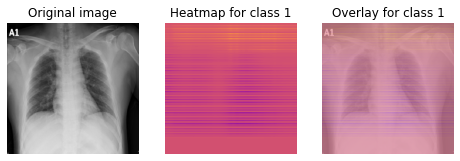

In [124]:
draw_original_and_heatmap(1)

(64, 2)
(64, 400, 400)


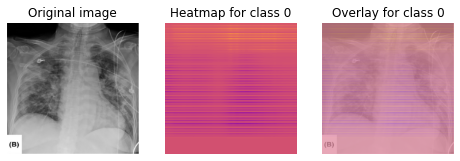

In [125]:
source_img = load_img('/gdrive/My Drive/covid-chestxray-dataset/images/all14238-fig-0001-m-b.jpg', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

draw_original_and_heatmap(0)

(64, 2)
(64, 400, 400)


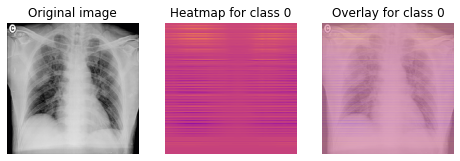

In [157]:
source_img = load_img('/gdrive/My Drive/covid-chestxray-dataset/images/jkms-35-e79-g001-l-c.jpg', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

draw_original_and_heatmap(0)

In [0]:
import tensorflow as tf
import numpy as np

class SaliencyMask(object):
  """Base class for saliency masks. Alone, this class doesn't do anything."""
  def __init__(self, graph, session, y, x):
    """Constructs a SaliencyMask by computing dy/dx.
    Args:
      graph: The TensorFlow graph to evaluate masks on.
      session: The current TensorFlow session.
      y: The output tensor to compute the SaliencyMask against. This tensor
          should be of size 1.
      x: The input tensor to compute the SaliencyMask against. The outer
          dimension should be the batch size.
    """

    # y must be of size one, otherwise the gradient we get from tf.gradients
    # will be summed over all ys.
    size = 1
    for shape in y.shape:
      size *= shape
    assert size == 1

    self.graph = graph
    self.session = session
    self.y = y
    self.x = x

  def GetMask(self, x_value, feed_dict={}):
    """Returns an unsmoothed mask.
    Args:
      x_value: Input value, not batched.
      feed_dict: (Optional) feed dictionary to pass to the session.run call.
    """
    raise NotImplementedError('A derived class should implemented GetMask()')

  def GetSmoothedMask(
      self, x_value, feed_dict={}, stdev_spread=.15, nsamples=25,
      magnitude=True, **kwargs):
    """Returns a mask that is smoothed with the SmoothGrad method.
    Args:
      x_value: Input value, not batched.
      feed_dict: (Optional) feed dictionary to pass to the session.run call.
      stdev_spread: Amount of noise to add to the input, as fraction of the
                    total spread (x_max - x_min). Defaults to 15%.
      nsamples: Number of samples to average across to get the smooth gradient.
      magnitude: If true, computes the sum of squares of gradients instead of
                 just the sum. Defaults to true.
    """
    stdev = stdev_spread * (np.max(x_value) - np.min(x_value))

    total_gradients = np.zeros_like(x_value)
    for i in range(nsamples):
      noise = np.random.normal(0, stdev, x_value.shape)
      x_plus_noise = x_value + noise
      grad = self.GetMask(x_plus_noise, feed_dict, **kwargs)
      if magnitude:
        total_gradients += (grad * grad)
      else:
        total_gradients += grad

    return total_gradients / nsamples

class GradientSaliency(SaliencyMask):
  r"""A SaliencyMask class that computes saliency masks with a gradient."""

  def __init__(self, graph, session, y, x):
    super(GradientSaliency, self).__init__(graph, session, y, x)
    self.gradients_node = tf.gradients(y, x)[0]

  def GetMask(self, x_value, feed_dict={}):
    """Returns a vanilla gradient mask.
    Args:
      x_value: Input value, not batched.
      feed_dict: (Optional) feed dictionary to pass to the session.run call.
    """
    feed_dict[self.x] = [x_value]
    return self.session.run(self.gradients_node, feed_dict=feed_dict)[0]
class IntegratedGradients(GradientSaliency):
  """A SaliencyMask class that implements the integrated gradients method.
  https://arxiv.org/abs/1703.01365
  """

  def GetMask(self, x_value, feed_dict={}, x_baseline=None, x_steps=25):
    """Returns a integrated gradients mask.
    Args:
      x_value: input ndarray.
      x_baseline: Baseline value used in integration. Defaults to 0.
      x_steps: Number of integrated steps between baseline and x.
    """
    if x_baseline is None:
      x_baseline = np.zeros_like(x_value)

    assert x_baseline.shape == x_value.shape

    x_diff = x_value - x_baseline

    total_gradients = np.zeros_like(x_value)

    for alpha in np.linspace(0, 1, x_steps):
      x_step = x_baseline + alpha * x_diff

      total_gradients += super(IntegratedGradients, self).GetMask(
          x_step, feed_dict)

    return total_gradients * x_diff / x_steps

In [41]:
from tensorflow.python.platform import googletest


class IntegratedGradientsTest(googletest.TestCase):
  """
  To run:
  "python -m saliency.integrated_gradients_test" from the PAIR-code/saliency
  directory.
  """

  def testIntegratedGradientsGetMask(self):
    with tf.Graph().as_default() as graph:
      x = tf.placeholder(shape=[None, 3], dtype=tf.float32)
      y = 5 * x[:, 0] + x[:, 0] * x[:, 1] + tf.sin(x[:, 2])
      with tf.Session() as sess:
        # Calculate the value of `y` at the baseline.
        x_baseline_val = np.array([[0.5, 0.8, 1.0]], dtype=np.float)
        y_baseline_val = sess.run(y, feed_dict={x: x_baseline_val})

        # Calculate the value of `y` at the input.
        x_input_val = np.array([[1.0, 2.0, 3.0]], dtype=np.float)
        y_input_val = sess.run(y, feed_dict={x: x_input_val})

        # Due to mathematical properties of the integrated gradients,
        # the expected IG value is equal to the difference between
        # the `y` value at the input and the `y` value at the baseline.
        expected_val = y_input_val[0] - y_baseline_val[0]

        # Calculate the integrated gradients attribution of the input.
        ig = integrated_gradients.IntegratedGradients(graph, sess, y[0], x)
        mask = ig.GetMask(x_value=x_input_val[0], feed_dict={},
                          x_baseline=x_baseline_val[0], x_steps=1000)

        # Verify the result.
        self.assertAlmostEqual(expected_val, mask.sum(), places=3)


if __name__ == '__main__':
  googletest.main()

Running tests under Python 3.6.9: /usr/bin/python3


UnrecognizedFlagError: ignored

In [0]:
#NOW LETS CHECK FOR A NORMAL CHEST RAY, THE ABOVE X-RAYS ARE COVID-AFFECTED.

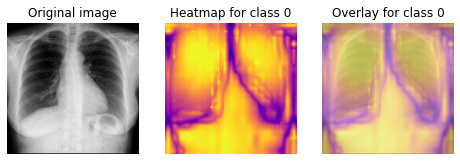

In [0]:
source_img = load_img('/gdrive/My Drive/normal_chestxray.jpeg', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

draw_original_and_heatmap(0)

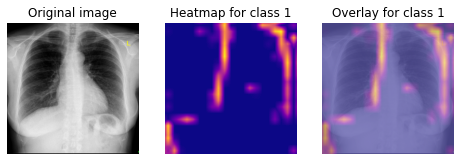

In [0]:
draw_original_and_heatmap(1)

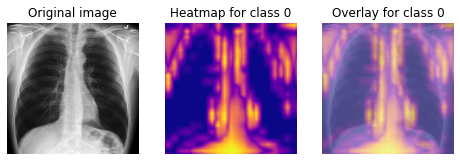

In [0]:
source_img = load_img('/gdrive/My Drive/chestxraynormal.jpg', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

draw_original_and_heatmap(0)

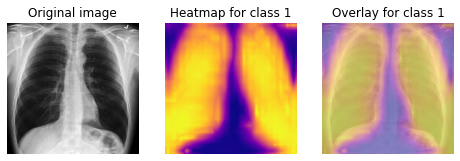

In [0]:
draw_original_and_heatmap(1)

In [0]:
#SIGNIFICANT CHANGE
#AS YOU CAN SEE, THERE ARE ABSOLUTELY NO FEATURES RECOGNIZED IN THE LUNG REGION OF THIS IMAGE
#BECAUSE THIS X-RAY IS OF A NORMAL HUMAN BEING.

In [0]:
import math
import warnings

import cv2
import numpy as np


def grid_display(array, num_rows=None, num_columns=None):
    """
    Display a list of images as a grid.
    Args:
        array (numpy.ndarray): 4D Tensor (batch_size, height, width, channels)
    Returns:
        numpy.ndarray: 3D Tensor as concatenation of input images on a grid
    """
    if num_rows is not None and num_columns is not None:
        total_grid_size = num_rows * num_columns
        if total_grid_size < len(array):
            warnings.warn(
                Warning(
                    "Given values for num_rows and num_columns doesn't allow to display "
                    "all images. Values have been overrided to respect at least num_columns"
                )
            )
            num_rows = math.ceil(len(array) / num_columns)
    elif num_rows is not None:
        num_columns = math.ceil(len(array) / num_rows)
    elif num_columns is not None:
        num_rows = math.ceil(len(array) / num_columns)
    else:
        num_rows = math.ceil(math.sqrt(len(array)))
        num_columns = math.ceil(math.sqrt(len(array)))

    number_of_missing_elements = num_columns * num_rows - len(array)
    # We fill the array with np.zeros elements to obtain a perfect square
    array = np.append(
        array,
        np.zeros((number_of_missing_elements, *array[0].shape)).astype(array.dtype),
        axis=0,
    )

    grid = np.concatenate(
        [
            np.concatenate(
                array[index * num_columns : (index + 1) * num_columns], axis=1
            )
            for index in range(num_rows)
        ],
        axis=0,
    )

    return grid


In [0]:
def transform_to_normalized_grayscale(tensor):
    """
    Transform tensor over RGB axis to grayscale.
    Args:
        tensor (tf.Tensor): 4D-Tensor with shape (batch_size, H, W, 3)
    Returns:
        tf.Tensor: 4D-Tensor of grayscale tensor, with shape (batch_size, H, W, 1)
    """
    grayscale_tensor = tf.math.reduce_sum(tensor, axis=-1, keepdims=True)


    #normalized_tensor = tf.cast(
    #    255 * tf.image.per_image_standardization(grayscale_tensor), tf.uint8
    #)

    return grayscale_tensor

In [0]:
from pathlib import Path

import cv2


def save_grayscale(image, output_dir, output_name):
    """
    Save a 3D Numpy array (H, W, 1) as an image.
    Args:
        image (numpy.ndarray): Image to save
        output_dir (str): Output directory
        output_name (str): Output name
    """
    Path.mkdir(Path(output_dir), parents=True, exist_ok=True)

    cv2.imwrite(str(Path(output_dir) / output_name), image)


In [0]:
import numpy as np
import tensorflow as tf

class IntegratedGradients:

    """
    Perform Integrated Gradients algorithm for a given input
    Paper: [Axiomatic Attribution for Deep Networks](https://arxiv.org/pdf/1703.01365.pdf)
    """

    def explain(self, validation_data, model, class_index, n_steps=10):
        """
        Compute Integrated Gradients for a specific class index
        Args:
            validation_data (Tuple[np.ndarray, Optional[np.ndarray]]): Validation data
                to perform the method on. Tuple containing (x, y).
            model (tf.keras.Model): tf.keras model to inspect
            class_index (int): Index of targeted class
            n_steps (int): Number of steps in the path
        Returns:
            np.ndarray: Grid of all the integrated gradients
        """
        images, _ = validation_data

        interpolated_images = IntegratedGradients.generate_interpolations(
            np.array(images), n_steps
        )

        integrated_gradients = IntegratedGradients.get_integrated_gradients(
            interpolated_images, model, class_index, n_steps
        )
        #print(type(integrated_gradients))
        grid = grid_display(integrated_gradients.numpy())

        return grid


    def get_integrated_gradients(interpolated_images, model, class_index, n_steps):
        """
        Perform backpropagation to compute integrated gradients.
        Args:
            interpolated_images (numpy.ndarray): 4D-Tensor of shape (N * n_steps, H, W, 3)
            model (tf.keras.Model): tf.keras model to inspect
            class_index (int): Index of targeted class
            n_steps (int): Number of steps in the path
        Returns:
            tf.Tensor: 4D-Tensor of shape (N, H, W, 3) with integrated gradients
        """
        with tf.GradientTape() as tape:
            inputs = tf.cast(interpolated_images, tf.float32)
            tape.watch(inputs)
            predictions = model(inputs)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, inputs)
        grads_per_image = tf.reshape(grads, (-1, n_steps, *grads.shape[1:]))

        integrated_gradients = tf.math.reduce_mean(grads_per_image, axis=1)

        return integrated_gradients

    def generate_interpolations(images, n_steps):
        """
        Generate interpolation paths for batch of images.
        Args:
            images (numpy.ndarray): 4D-Tensor of images with shape (N, H, W, 3)
            n_steps (int): Number of steps in the path
        Returns:
            numpy.ndarray: Interpolation paths for each image with shape (N * n_steps, H, W, 3)
        """
        baseline = np.zeros(images.shape[1:])

        return np.concatenate(
            [
                IntegratedGradients.generate_linear_path(baseline, image, n_steps)
                for image in images
            ]
        )

    def generate_linear_path(baseline, target, n_steps):
        """
        Generate the interpolation path between the baseline image and the target image.
        Args:
            baseline (numpy.ndarray): Reference image
            target (numpy.ndarray): Target image
            n_steps (int): Number of steps in the path
        Returns:
            List(np.ndarray): List of images for each step
        """
        return [
            baseline + (target - baseline) * index / (n_steps - 1)
            for index in range(n_steps)
        ]

    def save(self, grid, output_dir, output_name):
        """
        Save the output to a specific dir.
        Args:
            grid (numpy.ndarray): Grid of all the heatmaps
            output_dir (str): Output directory path
            output_name (str): Output name
        """
        save_grayscale(grid, output_dir, output_name)

In [0]:
source_img = load_img('/gdrive/My Drive/covid-chestxray-dataset/images/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day1.jpg', target_size=input_shape)
img = img_to_array(source_img)

print(type(img))

data = ([img], None)

print(type(data))

explainer = IntegratedGradients()
grid = explainer.explain(data, model, 0, n_steps=15)
explainer.save(grid, "/gdrive/My Drive/", "integrated_gradients.jpg")

<class 'numpy.ndarray'>
<class 'tuple'>


In [0]:

source_img = load_img('/gdrive/My Drive/covid-chestxray-dataset/images/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day1.jpg', target_size=input_shape)
img = img_to_array(source_img)

print(type(img))

data = ([img], None)

print(type(data))

explainer = IntegratedGradients()
grid = explainer.explain(data, model, 1, n_steps=15)
explainer.save(grid, "/gdrive/My Drive/", "integrated_gradients1.jpg")

<class 'numpy.ndarray'>
<class 'tuple'>
